# Implementation of Footstep Planner

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle
from pydrake.all import MathematicalProgram, OsqpSolver, eq, ge, le, QuadraticConstraint
from pydrake.solvers import MixedIntegerBranchAndBound
from pydrake.solvers import GurobiSolver
from IPython.display import HTML, display

## Make primitives for stepping stones

In [2]:
def plot_rectangle(center, width, height, ax=None, frame=0.1, **kwargs):
    if not "edgecolor" in kwargs:
        kwargs["edgecolor"] = "black"
    if not "facecolor" in kwargs:
        kwargs["facecolor"] = "none"
    if ax is None:
        ax = plt.gca()
    
    #get corners
    c2c = np.array([width, height]) / 2
    top_right = center + c2c
    bottom_left = center - c2c
    
    #plot rectangle
    rect = Rectangle(bottom_left, width, height, **kwargs)
    ax.add_patch(rect)
    
    ax.scatter(*bottom_left, s=0)
    ax.scatter(*top_right, s=0)
    
    ax.set_aspect("equal")
    return rect

class SteppingStone(object):
    def __init__(self, center, width, height, name=None):
        self.center = center
        self.width = width
        self.height = height
        self.name = name

        # distance from center to corners
        c2tr = np.array([width, height]) / 2
        c2br = np.array([width, -height]) / 2
        
        #pos of corners
        self.top_right = center + c2tr
        self.bottom_right = center + c2br
        self.top_left = center - c2br
        self.bottom_left = center - c2tr
        
        #halfspace representation of stepping stone
        #be inside all 4 sides
        # Ax <= b
        self.A = np.array([[1,0],[0,1],[-1,0],[0,-1]])
        self.b = np.concatenate([c2tr]*2) + self.A.dot(center)
        
    def plot(self, **kwargs):
        return plot_rectangle(self.center, self.width, self.height, **kwargs)


In [3]:
class Terrain(object):
    # parametric construction of the stepping stones
    # the following code adapts the position of each stepping
    # stone depending on the size and the sparsity of bool_bridge
    def __init__(self, bool_bridge):
        # ensure that bool_bridge has only boolean entries
        if any(i != bool(i) for i in bool_bridge):
            raise ValueError("Entry bool_bridge must be a list of boolean value.")

        # initialize internal list of stepping stones
        self.stepping_stones = []

        # add initial stepping stone to the terrain
        initial = self.add_stone([0, 0], 1, 1, "initial")

        # add bridge stepping stones to the terrain
        # gap between bridge stones equals bridge stone width
        width_bridge = 0.2
        center = initial.bottom_right + np.array(
            [width_bridge * 1.5, initial.height / 4]
        )
        centers = [
            center + np.array([i * 2 * width_bridge, 0])
            for i in np.where(bool_bridge)[0]
        ]
        self.add_stones(
            centers,
            [width_bridge] * sum(bool_bridge),
            [initial.height / 2] * sum(bool_bridge),
            "bridge",
        )

        # add goal stepping stone to the terrain
        # same dimensions of the initial one
        center = initial.center + np.array(
            [initial.width + (len(bool_bridge) * 2 + 1) * width_bridge, 0]
        )
        goal = self.add_stone(center, initial.width, initial.height, "goal")

        # add lateral stepping stone to the terrain
        height = 0.4
        clearance = 0.1
        c2g = goal.center - initial.center
        width = initial.width + c2g[0]
        center = (
            initial.center
            + c2g / 2
            + np.array([0, (initial.height + height) / 2 + clearance])
        )
        self.add_stone(center, width, height, "lateral")

    # adds a stone to the internal list stepping_stones
    def add_stone(self, center, width, height, name=None):
        stone = SteppingStone(center, width, height, name=name)
        self.stepping_stones.append(stone)
        return stone

    # adds multiple stones to the internal list stepping_stones
    def add_stones(self, centers, widths, heights, name=None):
        # ensure that inputs have coherent size
        n_stones = len(centers)
        if n_stones != len(widths) or n_stones != len(heights):
            raise ValueError("Arguments have incoherent size.")

        # add one stone per time
        stones = []
        for i in range(n_stones):
            stone_name = name if name is None else name + "_" + str(i)
            stones.append(
                self.add_stone(centers[i], widths[i], heights[i], name=stone_name)
            )

        return stones

    # returns the stone with the given name
    # raise a ValueError if no stone has the given name
    def get_stone_by_name(self, name):
        # loop through the stones
        # select the first with the given name
        for stone in self.stepping_stones:
            if stone.name == name:
                return stone

        # raise error if there is no stone with the given name
        raise ValueError(f"No stone in the terrain has name {name}.")

    # plots all the stones in the terrain
    def plot(self, title=None, **kwargs):
        # make light green the default facecolor
        if not "facecolor" in kwargs:
            kwargs["facecolor"] = [0, 1, 0, 0.1]

        # plot stepping stones disposition
        labels = ["Stepping stone", None]
        for i, stone in enumerate(self.stepping_stones):
            
            stone.plot(label=labels[min(i, 1)], **kwargs)

        # set title
        plt.title(title)

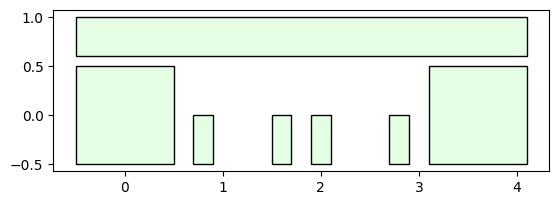

In [4]:
Terrain([1, 0, 1, 1, 0, 1]).plot()

In [5]:
def add_decision_variables(prog, terrain, n_steps):
    # number of stones
    n_stones = len(terrain.stepping_stones)
    
    #position of each foot
    position_left = prog.NewContinuousVariables(rows=n_steps+1,cols=2)
    position_right = prog.NewContinuousVariables(rows=n_steps+1,cols=2)
    
    # binaries that assign feet to stones for each step
    binary_left = prog.NewBinaryVariables(rows=n_steps+1, cols=n_stones)
    binary_right = prog.NewBinaryVariables(rows=n_steps+1, cols=n_stones)
    
    #which foot to move first
    first_left = prog.NewBinaryVariables(1)[0]
    
    return position_left, position_right, binary_left, binary_right, first_left

In [24]:
def relative_position_limits(prog, n_steps, step_span, decision_variables):
    # unpack only decision variables needed in this function
    position_left, position_right = decision_variables[:2]

    # modify here
    '''
        self.A = np.array([[1,0],[0,1],[-1,0],[0,-1]])
        self.b = np.concatenate([c2tr]*2) + self.A.dot(center)
    '''
    
    A = np.array([[1,0],[-1,0],[0,1],[0,-1]])
    b = np.array([step_span, step_span, step_span, step_span])
    for t in range(n_steps+1):
        left_rel_right = position_left[t] - position_right[t]
        right_rel_left = position_right[t] - position_left[t]
        
        
        prog.AddLinearConstraint(le(A@left_rel_right, b))
        prog.AddLinearConstraint(le(A@right_rel_left, b))
        
    # for t in range(1,n_steps+1):
    #     left_rel_right = position_left[t] - position_right[t-1]
    #     right_rel_left = position_right[t] - position_left[t-1]
        
    #     prog.AddLinearConstraint(le(A@left_rel_right, b))
    #     prog.AddLinearConstraint(le(A@right_rel_left, b))

In [25]:
def set_initial_and_goal_position(prog: MathematicalProgram, terrain: Terrain, decision_variables):
    position_left, position_right = decision_variables[:2]
    
    #initial position of feet of robot
    foot_offset = np.array([0, 0.2])
    
    #initial pos of feet
    center = terrain.get_stone_by_name("initial").center
    initial_position_left = center
    initial_position_right = center - foot_offset
    
    #goal position of feet
    center = terrain.get_stone_by_name("goal").center
    goal_position_left = center
    goal_position_right = center - foot_offset
    
    #enforce initial position of feet
    prog.AddLinearConstraint(eq(position_left[0], initial_position_left))
    prog.AddLinearConstraint(eq(position_right[0], initial_position_right))
    
    #enforce goal position of feet
    prog.AddLinearConstraint(eq(position_left[-1], goal_position_left))
    prog.AddLinearConstraint(eq(position_right[-1], goal_position_right))

In [26]:
def step_sequence(prog, n_steps, step_span, decision_variables):
    position_left, position_right = decision_variables[:2]
    first_left = decision_variables[-1]
    
    first_right = 1 - first_left
    
    #limit the distance between steps
    step_limit = np.ones(2)*step_span
    
    for t in range(n_steps):
        #length of steps
        step_left = position_left[t+1] - position_left[t]
        step_right = position_right[t+1] - position_right[t]
        
        #even steps
        if t % 2 == 0:
            limit_left = step_limit * first_left
            limit_right = step_limit * first_right
        else: #odd steps
            limit_left = step_limit * first_right
            limit_right = step_limit * first_left
            
        # constraint on left-foot relative position
        # lower_limit <= step_left <= upper_limit
        prog.AddLinearConstraint(le(step_left, limit_left))
        prog.AddLinearConstraint(ge(step_left, -limit_left))
        
        # constraint on right-foot relative position
        # lower_limit <= step_right <= upper_limit
        prog.AddLinearConstraint(le(step_right, limit_right))
        prog.AddLinearConstraint(ge(step_right, -limit_right))

In [27]:
def one_stone_per_foot(prog, n_steps, decision_variables):
    # unpack only decision variables needed in this function
    stone_left, stone_right = decision_variables[2:4]

    # modify here
    
    # each foot is on exactly one stone at each step
    for t in range(n_steps+1):
        prog.AddLinearConstraint(eq(stone_left[t].sum(), np.ones(1)))
        prog.AddLinearConstraint(eq(stone_right[t].sum(), np.ones(1)))

In [28]:
# parameter for the big-M method
# carefully chosen for the terrain above
def get_big_M(terrain):
    # big-M parameter for the horizontal axis
    initial = terrain.get_stone_by_name("initial")
    goal = terrain.get_stone_by_name("goal")
    M = [goal.center[0] - initial.center[0]]

    # big-M parameter for the vertical axis
    lateral = terrain.get_stone_by_name("lateral")
    M.append(lateral.top_right[1] - initial.center[1])

    return np.array(M * 2)

In [29]:
def foot_in_stepping_stone(prog, terrain, n_steps, decision_variables):
    # unpack only decision variables needed in this function
    (
        position_left,
        position_right,
        stone_left,
        stone_right,
    ) = decision_variables[:4]

    # big-M vector
    M = get_big_M(terrain)

    n_stones = len(terrain.stepping_stones)

    # modify here
    for stone in range(n_stones):
        # A_i x_t <= b_i + M_i (1 - stone_i_t)
        A = terrain.stepping_stones[stone].A
        b = terrain.stepping_stones[stone].b
        for t in range(n_steps+1):
            prog.AddLinearConstraint(le(A.dot(position_left[t]), b + M * (1 - stone_left[t, stone])))
            prog.AddLinearConstraint(le(A.dot(position_right[t]), b + M * (1 - stone_right[t, stone])))

In [30]:
def minimize_step_length(prog, n_steps, decision_variables):
    # unpack only decision variables needed in this function
    position_left, position_right = decision_variables[:2]

    # modify here
    for t in range(n_steps):
        step_length_left = position_left[t+1] - position_left[t]
        step_length_right = position_right[t+1] - position_right[t]
        
        prog.AddQuadraticCost(step_length_left.dot(step_length_left))
        prog.AddQuadraticCost(step_length_right.dot(step_length_right))

In [31]:
def footstep_planner(terrain, n_steps, step_span):
    # initialize optimization problem
    prog = MathematicalProgram()

    # optimization variables
    decision_variables = add_decision_variables(prog, terrain, n_steps)

    # constraints
    set_initial_and_goal_position(prog, terrain, decision_variables)
    relative_position_limits(prog, n_steps, step_span, decision_variables)
    step_sequence(prog, n_steps, step_span, decision_variables)
    one_stone_per_foot(prog, n_steps, decision_variables)
    foot_in_stepping_stone(prog, terrain, n_steps, decision_variables)

    # objective function
    minimize_step_length(prog, n_steps, decision_variables)

    # print prog possible solvers

    # solve
    bb = MixedIntegerBranchAndBound(prog, OsqpSolver().solver_id())
    result = bb.Solve()

    # ensure that the problem is feasible
    if result != result.kSolutionFound:
        raise ValueError("Infeasible optimization problem.")

    # retrieve result of the optimization
    decision_variables_opt = [bb.GetSolution(v) for v in decision_variables]
    objective_opt = bb.GetOptimalCost()

    return decision_variables_opt, objective_opt

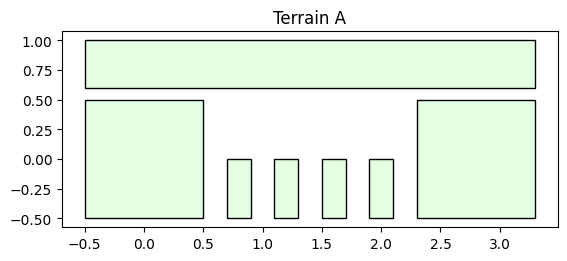

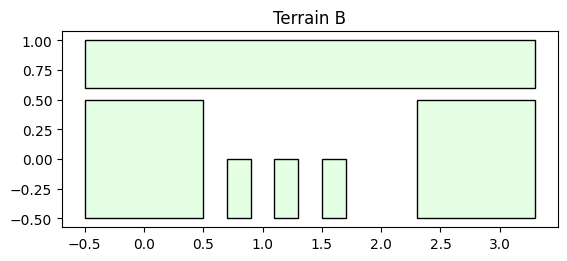

In [32]:
# complete bridge
terrain_A = Terrain([1, 1, 1, 1])
terrain_A.plot("Terrain A")
plt.show()

# one stepping stone missing in the bridge
terrain_B = Terrain([1, 1, 1, 0])
terrain_B.plot("Terrain B")
plt.show()

In [33]:
# maximum number of steps to reach the goal
n_steps = 10

# side of the square that limits each step
step_span = 1.0

In [34]:
def animate_footstep_plan(
    terrain, step_span, position_left, position_right, title=None
):
    # initialize figure for animation
    fig, ax = plt.subplots()

    # plot stepping stones
    terrain.plot(title=title, ax=ax)

    # initial position of the feet
    left_foot = ax.scatter(0, 0, color="r", zorder=3, label="Left foot")
    right_foot = ax.scatter(0, 0, color="b", zorder=3, label="Right foot")

    # initial step limits
    left_limits = plot_rectangle(
        [0, 0],  # center
        step_span,  # width
        step_span,  # eight
        ax=ax,
        edgecolor="b",
        label="Left-foot limits",
    )
    right_limits = plot_rectangle(
        [0, 0],  # center
        step_span,  # width
        step_span,  # eight
        ax=ax,
        edgecolor="r",
        label="Right-foot limits",
    )

    # misc settings
    plt.close()
    ax.legend(loc="upper left", bbox_to_anchor=(0, 1.3), ncol=2)

    def animate(n_steps):
        # scatter feet
        left_foot.set_offsets(position_left[n_steps])
        right_foot.set_offsets(position_right[n_steps])

        # limits of reachable set for each foot
        c2c = np.ones(2) * step_span / 2
        right_limits.set_xy(position_left[n_steps] - c2c)
        left_limits.set_xy(position_right[n_steps] - c2c)

    # create ad display animation
    ani = FuncAnimation(fig, animate, frames=n_steps + 1, interval=1e3)
    display(HTML(ani.to_jshtml()))


def generate_and_animate_footstep_plan(terrain, n_steps, step_span, title=None):
    # run footstep planner
    decision_variables, objective = footstep_planner(terrain, n_steps, step_span)

    # animate result
    animate_footstep_plan(terrain, step_span, *decision_variables[:2], title)

In [35]:
generate_and_animate_footstep_plan(terrain_A, n_steps, step_span, "Terrain A")
generate_and_animate_footstep_plan(terrain_B, n_steps, step_span, "Terrain B")

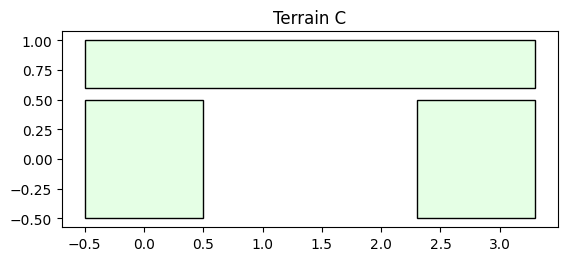

In [33]:
# complete bridge
terrain_C = Terrain([0, 0, 0, 0])
terrain_C.plot("Terrain C")
plt.show()

In [34]:
generate_and_animate_footstep_plan(terrain_C, n_steps, step_span, "Terrain C")